<a href="https://colab.research.google.com/github/hosngholami/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install opendatasets
!pip install geopy
!pip install folium

In [3]:
import opendatasets
opendatasets.download('https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hosngholami97
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset


100%|██████████| 4.07G/4.07G [02:29<00:00, 29.3MB/s]


In [4]:
import json
import pandas as pd
data_file = open("/content/yelp-dataset/yelp_academic_dataset_business.json")
data = []
for line in data_file:
  data.append(json.loads(line))
bussines_df = pd.DataFrame(data)
data_file.close()

In [5]:
df = bussines_df[bussines_df["state"] == "CA"]

In [15]:
import random



hotel = df[df["categories"].str.contains("Hotel", case=False, na=False)]
attractions = df[df['categories'].str.contains('Tourist Attraction|Landmark|Museum|Park|Zoo|Nature', case=False, na=False)]
restaurants = df[(df['categories'].str.contains('Restaurant', case=False, na=False))]
cafeShop = df[(df['categories'].str.contains('Cafe|Coffee', case=False, na=False)) & (df['state'] == 'CA')]


hotel["id"] = [i for i in range(len(hotel))]


h1 = hotel.sample(n=1)




hotel["price"] = [random.randint(1, 100) for i in range(len(hotel))]
attractions["price"] = [random.randint(1, 100) for i in range(len(attractions))]
restaurants["price"] = [random.randint(1, 100) for i in range(len(restaurants))]
cafeShop["price"] = [random.randint(1, 100) for i in range(len(cafeShop))]



scinecSpot = pd.concat([attractions, restaurants, cafeShop], ignore_index=True)
scinecSpot["id"] = [i for i in range(len(scinecSpot))]



locations =len(scinecSpot)
scinecSpot
# historic = df[df['categories'].str.contains('Historic Site|Landmark|Museum|Heritage', case=False, na=False)]
# hospitals = df[df['categories'].str.contains('Hospital', case=False, na=False)]
# bikeStations = df[df['categories'].str.contains('Bike Station|Bike Rental', case=False, na=False)]
# cinemas = df[df['categories'].str.contains('Cinema|Movie Theater', case=False, na=False)]
# events = df[df['categories'].str.contains('Event|Concert|Festival|Exhibition|Show', case=False, na=False)]
# artGalleries = df[df['categories'].str.contains('Art Gallery|Gallery', case=False, na=False)]
# Waterfall = df[df['categories'].str.contains('Waterfall', case=False, na=False)]
# culturalCenters = df[df['categories'].str.contains('Cultural Center|Arts & Entertainment|Museums|Theater', case=False, na=False)]



# lat_long = culturalCenters[["latitude", "longitude", "categories"]]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,price,id
0,VeIrgRMOK_0ZToziUd2kUA,Franceschi Park,1510 Mission Ridge Rd,Santa Barbara,CA,93103,34.439926,-119.693914,4.5,26,1,"{'GoodForKids': 'True', 'BusinessParking': '{'...","Parks, Active Life","{'Monday': '7:30-16:30', 'Tuesday': '7:30-16:3...",52,0
1,B5XSoSG3SfvQGtKEGQ1tSQ,Los Padres National Forest,San Marcos Pass Rd,Santa Barbara,CA,93105,34.597239,-119.510772,4.5,13,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Parks, Active Life",None,35,1
2,dGVsh3S39RlPj_MfBZklZQ,Elings Park,1298 Las Positas Rd,Santa Barbara,CA,93105,34.411454,-119.735932,4.5,44,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Active Life, Playgrounds, Parks",None,33,2
3,8kp1eqQflG1bHCTXnITnqA,El Presidio de Santa Bárbara State Historic Park,123 E Canon Perdido St,Santa Barbara,CA,93101,34.422699,-119.698860,4.0,31,1,{'GoodForKids': 'True'},"Museums, Landmarks & Historical Buildings, Art...","{'Monday': '10:30-16:30', 'Tuesday': '10:30-16...",57,3
4,6JFTijOMHB46yBoyVOjPCA,Santa Barbara County Courthouse,1100 Anacapa St,Santa Barbara,CA,93101,34.424201,-119.702328,4.5,251,1,"{'GoodForKids': 'True', 'BusinessParking': '{'...","Courthouses, Active Life, Event Planning & Ser...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",79,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,0f0l62WKla-j2cfnPn7P2Q,The Coffee Bean & Tea Leaf,5745 Calle Real,Goleta,CA,93117,34.440840,-119.824488,3.5,70,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Coffee & Tea, Food","{'Monday': '5:30-20:0', 'Tuesday': '5:30-20:0'...",80,1474
1475,BBBT3Mogjo3hPPA0de--Dw,Le Café,"6533 Trigo Rd, Ste 106",Isla Vista,CA,93117,34.410842,-119.855236,2.5,10,0,"{'RestaurantsAttire': ''casual'', 'DogsAllowed...","French, Coffee & Tea, Food, Restaurants, Break...","{'Monday': '8:0-13:0', 'Tuesday': '8:0-13:0', ...",23,1475
1476,hDr_bt6MEwlGvGCCKzyzhg,Goleta Coffee Co and Loca Vivant Kitchen,177 S Turnpike Rd,Santa Barbara,CA,93111,34.437517,-119.790939,4.0,187,1,"{'RestaurantsPriceRange2': '1', 'BusinessParki...","Restaurants, Coffee & Tea, Breakfast & Brunch,...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-15:0', '...",81,1476
1477,izSgTrqebu8bN8ONOCs6cQ,Oat Bakery,5 W Haley St,Santa Barbara,CA,93101,34.416548,-119.695626,5.0,123,1,"{'Alcohol': 'u'none'', 'HasTV': 'False', 'Bike...","Bakeries, Vegan, Specialty Food, Food Delivery...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-18:0', '...",98,1477


In [7]:
!pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.9 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=6ba21c11c8afa71b145666f51d2141d41d3b8a37953aa794684bac40e09e1284
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


Initial Population:
[[ 183  166  533  989  421 1149 1284  183]
 [ 183 1476  164  567 1457   39 1075  183]
 [ 183  405  526  582  250  844  682  183]
 [ 183  219  765  856  375  414   45  183]
 [ 183  452  931 1455  942  119 1032  183]
 [ 183  495 1104  406 1225 1432 1475  183]
 [ 183 1351  480   62 1024  869  625  183]
 [ 183 1219 1372 1357  537  725  909  183]
 [ 183  138  928  869  816  590  908  183]
 [ 183  802  818 1153  594 1301 1159  183]
 [ 183 1208  729  908 1271  144  492  183]
 [ 183   96   87 1101 1281   24  817  183]
 [ 183  282 1268  700  305  941 1436  183]
 [ 183  202  606 1054 1081 1105  118  183]
 [ 183  542  817  753  759  205   78  183]
 [ 183 1168  457  180  934   23 1250  183]
 [ 183  952  806  962  736 1368 1258  183]
 [ 183  961   95  840 1381 1078 1099  183]
 [ 183  416  126  220  243  470 1068  183]
 [ 183  680  683  168  862  559   29  183]
 [ 183  746 1252   22  244 1335 1081  183]
 [ 183  281  150  914  645 1151  367  183]
 [ 183  671  389 1395  350  678 13

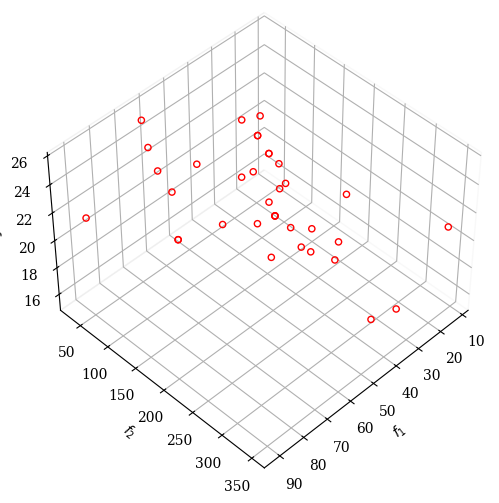

In [22]:
import random
import numpy as np
import folium

from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
from pymoo.core.callback import Callback
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.selection import Selection
from pymoo.visualization.scatter import Scatter


class ValidatePopulationCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = []  # نگه‌داشتن تاریخچه جمعیت‌های معتبر

    def notify(self, algorithm):
        # ترکیب والدین و فرزندان
        combined_population = np.vstack([algorithm.pop.get("X"), algorithm.off.get("X")])

        old_pop = algorithm.pop.get("X")
        new_pop = algorithm.off.get("X")
        # print('old_pop')
        # for i in range(len(old_pop)):
        #    print([int(item) for item in old_pop[i]])
        # print('new_pop')
        # for i in range(len(new_pop)):
        #    print([int(item) for item in new_pop[i]])
        # print('-------')
        # اصلاح جمعیت جدید
        new_population = np.zeros_like(combined_population)  # جمعیت جدید اصلاح‌شده

        for i in range(len(combined_population)):
            # اصلاح هر فرد از جمعیت
            individual = combined_population[i]

            # اصلاح فرد با استفاده از روش‌های مورد نظر (مثلاً ایجاد یک راه‌حل معتبر)
            # فرض کنید تابع اصلاحی createValidSolution این کار را انجام می‌دهد
            individual = self.repair_individual(individual)

            # اصلاح فرد در جمعیت جدید
            new_population[i] = individual
        F = np.zeros((new_population.shape[0], algorithm.problem.n_obj))
        algorithm.problem._evaluate(new_population, out={"F": F})


        # به روز رسانی جمعیت با جمعیت اصلاح‌شده
        # اطمینان از هم‌خوانی اندازه جمعیت
        if new_population.shape[0] == algorithm.pop.size:
            algorithm.pop.set("X", new_population)
        else:
            # اگر تعداد تغییر کرده، تعداد جمعیت را مطابق با نیاز تنظیم کنید
            algorithm.pop.set("X", new_population[:algorithm.pop.size])

    def repair_individual(self, individual):
        individual[0] = h1["id"]
        individual[-1] = h1["id"]

        return individual


class CustomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)

        for row in samples:
            while True:
              sample = [0 for _ in range(n_var)]
              sample[0] = h1["id"]

              for i in range(1,n_var-1):
                s = scinecSpot.sample(n=1)
                sample[i] = s["id"]
              sample[n_var-1] = h1["id"]


              for i in range(len(row)):
                row[i] = sample[i]
              break

        print("Initial Population:")
        print(samples)

        print('---------------------')

        return samples


def getObjective(routes):
    total_distance = []
    total_cost = []
    total_rate = []


    for route in routes:


        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0

        start_lat = h1.iloc[0]["latitude"]
        start_lon = h1.iloc[0]["longitude"]


        end = scinecSpot[scinecSpot["id"] == route[1]]
        end_lat = end.iloc[0]["latitude"]
        end_lon = end.iloc[0]["longitude"]




        distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)

        for i in range(1, len(route) - 2):
            start, end = int(route[i]), int(route[i + 1])

            start = scinecSpot[scinecSpot["id"] == start]
            end = scinecSpot[scinecSpot["id"] == end]

            start_lat, start_lon = start.iloc[0]["latitude"], start.iloc[0]["longitude"]
            end_lat, end_lon = end.iloc[0]["latitude"], end.iloc[0]["longitude"]


            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)

        for i in range(1, len(route) - 1):
          node = scinecSpot[scinecSpot["id"] == route[i]]

          rate +=  node.iloc[0]["stars"]

        start_lat = h1.iloc[0]["latitude"]
        start_lon = h1.iloc[0]["longitude"]

        for i in range(1, len(route)-1):
            start = scinecSpot[scinecSpot["id"] == route[i]]
            cost += start.iloc[0]["price"]

        end = scinecSpot[scinecSpot["id"] == route[6]]
        end_lat = end.iloc[0]["latitude"]
        end_lon = end.iloc[0]["longitude"]

        distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)



        print(f"route: {route} -> d: {distance}, c: {cost}")
        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(rate)

    return (total_distance, total_cost, total_rate)


# مدل و الگوریتم NSGA-II
class HotelRouteProblem(Problem):
    def __init__(self):
        super().__init__(n_var=8, n_obj=3, n_constr=0, xl=0, xu=locations - 1, type_var=int)

    def _evaluate(self, x, out, *args, **kwargs):
        total_distance, total_cost, total_rate = getObjective(x)
        # for i in range(len(total_distance)):
        #     print(f"total_distance: {total_distance[i]}, cost: {total_cost[i]}")
        out["F"] = np.column_stack([total_distance, total_cost, total_rate])






class CustomeCrossover(Crossover):
    def __init__(self):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):

        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)

        for k in range(n_matings):
            while True:
                # انتخاب والدین
                parent1 = [int(item) for item in X[0, k]]
                parent2 = [int(item) for item in X[1, k]]



                # انتخاب نقطه تصادفی
                # point = np.random.randint(1, n_var)

                # # تولید فرزندان
                # child1 = np.hstack([parent1[:point], parent2[point:]])
                # child2 = np.hstack([parent2[:point], parent1[point:]])

                child1 = np.hstack([parent1[0], parent1[1:4], parent2[4:7], parent1[-1]])
                child2 = np.hstack([parent2[0], parent2[1:4], parent1[4:7], parent2[-1]])
                # print(f"parent1: {parent1}")
                # print(f"parent2: {parent2}")
                # print(f"child1: {child1}")
                # print(f"child2: {child2}")
                # print("--------------")
                break


            # ذخیره فرزندان
            Y[0, k] = child1
            Y[1, k] = child2

        return Y








algorithm = NSGA2(pop_size=100,
                  sampling=CustomSampling(),
                  crossover=CustomeCrossover(),
                  callback=ValidatePopulationCallback())


problem = HotelRouteProblem()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               verbose=False)



best_index = np.argmin(res.F[:, 2])
best_route = res.X[best_index].astype(int)
best_distance = res.F[best_index, 0]
best_cost = res.F[best_index, 1]
best_rate = res.F[best_index, 2]

print('---------------')
print("Best Route (order of locations):", best_route)
print("Best Distance:", best_distance)
print("Best Cost:", best_cost)
print("Best rate:", best_rate)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()



In [23]:
import folium
from geopy.distance import geodesic

from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim


geolocator = Nominatim(user_agent="location_details")

map=folium.Map(location=[h1["latitude"], h1["longitude"]], zoom_start=15)



for route in best_route:
  s = scinecSpot[scinecSpot["id"] == route]
  print(s.iloc[0]["latitude"], s.iloc[0]["longitude"])
  latitude = s["latitude"]
  longitude = s["longitude"]
  category = s["categories"]
  map.add_child(folium.Marker(location=[latitude, longitude], popup=f"{latitude},{longitude},{category}",icon=folium.Icon(color='red')))

map.add_child(folium.Marker(location=[h1["latitude"], h1["longitude"]],icon=folium.Icon(color='green')))

34.4132969412 -119.8551685799
34.41716 -119.6990213
34.419192 -119.698318
34.423515 -119.706222
34.4131069 -119.688496
34.4275624 -119.687371
34.4298966 -119.8687832057
34.4132969412 -119.8551685799


In [10]:
import folium
from geopy.distance import geodesic

from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim


geolocator = Nominatim(user_agent="location_details")

map=folium.Map(location=[h1["latitude"], h1["longitude"]], zoom_start=15)



for index, row in scinecSpot.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    map.add_child(folium.Marker(location=[latitude, longitude], popup=f"{latitude},{longitude},{category}",icon=folium.Icon(color='red')))

map.add_child(folium.Marker(location=[h1["latitude"], h1["longitude"]],icon=folium.Icon(color='green')))




In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl


Alpha = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Alpha')
Alpha["low"] = fuzz.trimf(Alpha.universe, [0, 0, 0.5])
Alpha["Medium"] = fuzz.trimf(Alpha.universe, [0.25, 0.5, 0.75])
Alpha["high"] = fuzz.trimf(Alpha.universe, [0.5, 1, 1])

def compute_hotel_service_cost(low, high, alpha):
  medium = (high + low) / 2

  Cost = ctrl.Consequent(np.arange(0, 1001, 1), 'Cost')
  Cost["low"] = fuzz.trimf(Cost.universe, [0, 0, medium])
  Cost["Medium"] = fuzz.trimf(Cost.universe, [(low + medium) / 2, medium, (high + medium) / 2])
  Cost["high"] = fuzz.trimf(Cost.universe, [medium, high, high])



  # Alpha.view()
  # Cost.view()


  rule1 = ctrl.Rule(Alpha['low'], Cost['low'])
  rule2 = ctrl.Rule(Alpha['Medium'], Cost['Medium'])
  rule3 = ctrl.Rule(Alpha['high'], Cost['high'])

  CostCondition_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
  CostCondition = ctrl.ControlSystemSimulation(CostCondition_ctrl)


  CostCondition.input['Alpha'] = alpha

  CostCondition.compute()

  print(CostCondition.output['Cost'])
  # Cost.view(sim=CostCondition)



hotels = [
    {'low': 50, 'high': 250},
    {'low': 200, 'high': 500},
    {'low': 300, 'high': 600},
]


for i, hotel in enumerate(hotels):
  low = hotel['low']
  high = hotel['high']
  alpha = 0.9

  compute_hotel_service_cost(low, high, alpha)

In [ ]:
# !cp /content/yelp_review.json /content/drive/MyDrive/yelp-dataset/yelp-dataset


In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.2 MB/s eta 0:00:00


19.847607361963192


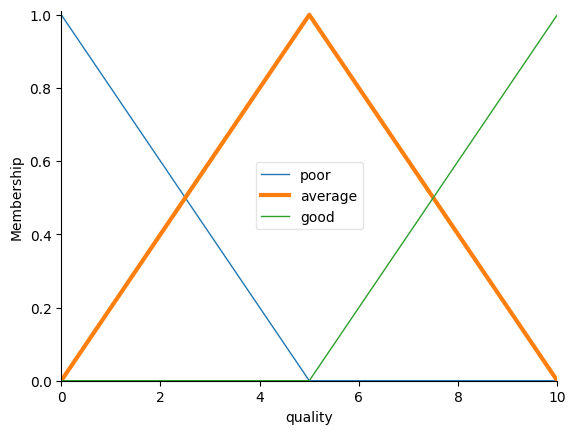

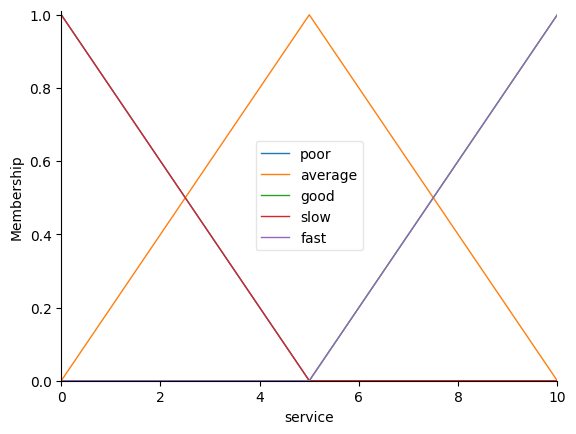

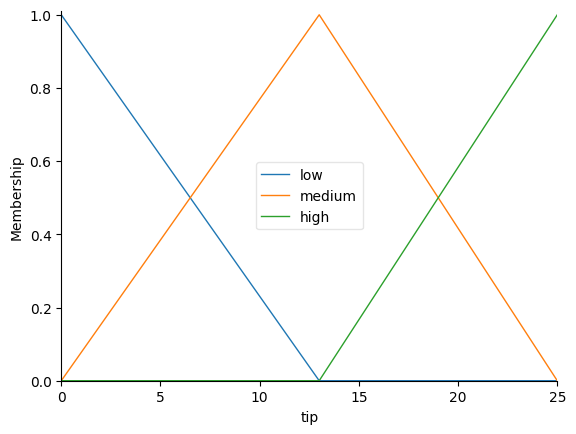

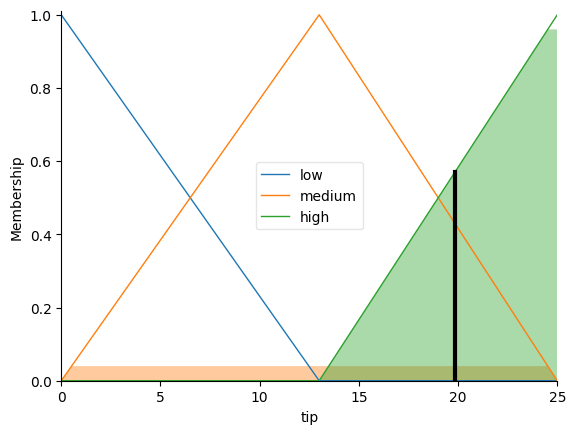

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
tip = ctrl.Consequent(np.arange(0, 26, 1), 'tip')

# Auto-membership function population is possible with .automf(3, 5, or 7)
quality.automf(3)
service.automf(3)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])

quality['poor'] = fuzz.trimf(quality.universe, [0, 0, 5])
quality['average'] = fuzz.trimf(quality.universe, [0, 5, 10])
quality['good'] = fuzz.trimf(quality.universe, [5, 10, 10])

service['slow'] = fuzz.trimf(service.universe, [0, 0, 5])
service['average'] = fuzz.trimf(service.universe, [0, 5, 10])
service['fast'] = fuzz.trimf(service.universe, [5, 10, 10])

quality['average'].view()
service.view()
tip.view()

rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])

tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input['quality'] = 6.5
tipping.input['service'] = 9.8

# Crunch the numbers
tipping.compute()

print(tipping.output['tip'])
tip.view(sim=tipping)

In [ ]:
!pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.7 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=c273c458dbf05730cb168275236c6502fc92d2397fb26fe5710fbd1176877195
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
import numpy as np
import pandas as pd
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
import random

In [ ]:
distance_matrix = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

  ]



cost_matrix = []


def setCost():
  for i in range(12):
    cost_matrix.append(random.randint(10, 80))
  print(cost_matrix)


setCost()

def setDistance():
  for i in range(12):
    for j in range(12):
      if (i == j):
        distance_matrix[i][j] = 0
      else:
        distance_matrix[i][j] = random.randint(1, 200)

  print(pd.DataFrame(distance_matrix))

setDistance()

def getDistance(i, j):
  return distance_matrix[i][j]

def getCost(i):
  return cost_matrix[i]

[54, 12, 49, 66, 18, 24, 43, 60, 63, 13, 46, 26]
     0    1    2    3    4    5    6    7    8    9    10   11
0     0  123  140  172   34   88  141   93  164  120  178  197
1     2    0  106   86   14   77  116   46   58   70  130   66
2   180  107    0    8   64  115   50  148   67  156   37  143
3    26   68  166    0   10  127   87  102  169   15   68  167
4    36   28  147  104    0  165  154  172   46   92  120  103
5   121   81   98   34  196    0   52  103   13  183  161  125
6    57  142   12  171   40   22    0  113   29  200  152  199
7    61  165   27   45  146  142  105    0  181   28  197  114
8   150   52    6  136   19  100   46   78    0   72   89   54
9   180  188   49  142   42   37   60  125   85    0  131   28
10  154    1   47   47  105  148  147  172   80   62    0   67
11  113   92   97   90   93  164  118   27  144   56  117    0


In [ ]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population

hotels = [0, 1, 2, 3]
restaurants = [4, 5, 6, 7]
science_spots = [8, 9, 10, 11]
locations = hotels + restaurants + science_spots

pop_size = 5
mt = 4

initial_population = []
for _ in range(pop_size):
    route = random.sample(locations, mt)
    initial_population.append(route)

initial_population = np.array(initial_population, dtype=int)

for route in initial_population:
   distance = 0
   cost = 0
   for i in range(len(route) - 1):
      start, end = route[i], route[i + 1]
      # print(getDistance(start, end))
      distance += getDistance(start, end)

   for j in range(len(route)):
      cost += getCost(route[j])

   print(f"{route} => distance : {distance}, cost: {cost}")

initial_population = Population.new("X", initial_population)


class HotelRouteProblem(Problem):
    def __init__(self):
        super().__init__(n_var=mt, n_obj=2, n_constr=0, xl=0, xu=len(locations) - 1, type_var=int)  # n_obj=2 برای بهینه‌سازی چندهدفه

    def _evaluate(self, x, out, *args, **kwargs):
        total_distance = []
        total_cost = []
        for route in x:
            route = route.astype(int)
            distance = 0
            cost = 0
            for i in range(len(route) - 1):
                start, end = route[i], route[i + 1]
                distance += getDistance(start, end)

            for j in range(len(route)):
                cost += getCost(route[j])

            total_distance.append(distance)
            total_cost.append(cost)

        out["F"] = np.column_stack([total_distance, total_cost])


problem = HotelRouteProblem()

algorithm = NSGA2(pop_size=pop_size, sampling=initial_population)

res = minimize(problem, algorithm, ('n_gen', 200), verbose=True)

best_index = np.argmin(res.F[:, 1])  # یافتن ایندکس با کمترین هزینه

best_route = res.X[best_index].astype(int)
best_distance = res.F[best_index, 0]
best_cost = res.F[best_index, 1]

print('---------------')
print("Best Route (order of locations):", best_route)
print("Best Distance:", best_distance)
print("Best Cost:", best_cost)


[ 6  8  9 11] => distance : 305, cost: 167
[0 3 4 7] => distance : 328, cost: 178
[ 6  7 10  9] => distance : 541, cost: 200
[9 8 2 1] => distance : 330, cost: 224
[10  6  9  0] => distance : 271, cost: 253
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        5 |      2 |             - |             -
     2 |       10 |      1 |  4.900000E+01 |         ideal
     3 |       15 |      4 |  0.7443609023 |         ideal
     4 |       20 |      5 |  0.000000E+00 |             f
     5 |       25 |      5 |  0.000000E+00 |             f
     6 |       30 |      5 |  0.000000E+00 |             f
     7 |       35 |      5 |  0.4956521739 |         ideal
     8 |       40 |      5 |  0.0211227264 |             f
     9 |       45 |      5 |  0.1142085599 |             f
    10 |       50 |      5 |  0.000000E+00 |             f
    11 |       55 |      5 |  0.000000E+00 |             f
    12 |       60 |      5 |  0.000000E+00 |             f
    13 |       65 |      5

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.1 MB/s eta 0:00:00


الگوریتم فازی - برای هر هتل سه مقدار بدبینانه،خوش بینانه و متوسط رو در نظر می گیریم

46.944218357553886


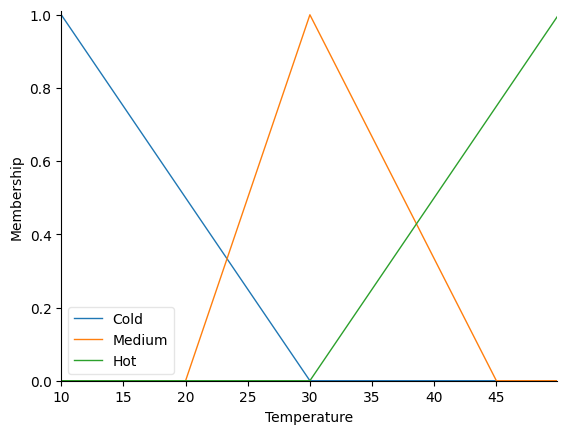

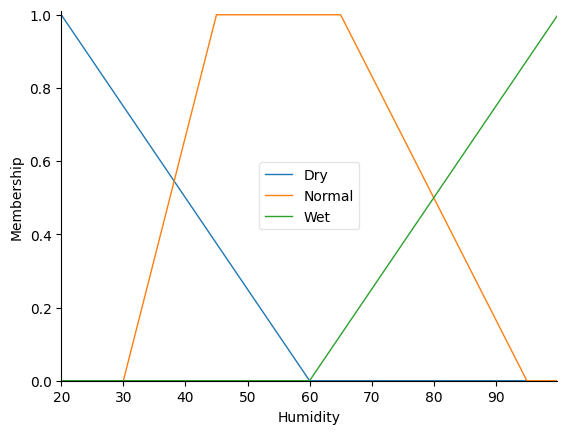

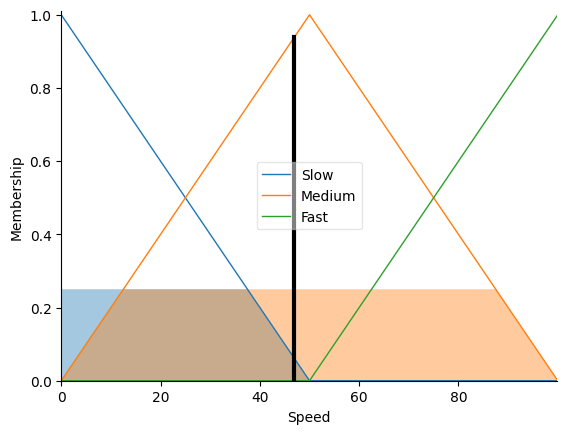

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl


Temperature = ctrl.Antecedent(np.arange(10, 50, 0.1), 'Temperature')
Temperature["Cold"] = fuzz.trimf(Temperature.universe, [10, 10, 30])
Temperature["Medium"] = fuzz.trimf(Temperature.universe, [20, 30, 45])
Temperature["Hot"] = fuzz.trimf(Temperature.universe, [30, 50, 50])


Humidity = ctrl.Antecedent(np.arange(20, 100, 0.1), 'Humidity')
Humidity["Dry"] = fuzz.trimf(Humidity.universe, [20, 20, 60])
Humidity["Normal"] = fuzz.trapmf(Humidity.universe, [30, 45, 65, 95])
Humidity["Wet"] = fuzz.trimf(Humidity.universe, [60, 100, 100])

Speed = ctrl.Consequent(np.arange(0, 100, 0.1), 'Speed')
Speed["Slow"] = fuzz.trimf(Speed.universe, [0, 0, 50])
Speed["Medium"] = fuzz.trimf(Speed.universe, [0, 50, 100])
Speed["Fast"] = fuzz.trimf(Speed.universe, [50, 100, 100])

Temperature.view()
Humidity.view()



rule1 = ctrl.Rule(Temperature['Cold'] & Humidity['Wet'], Speed['Slow'])
rule2 = ctrl.Rule(Temperature['Cold'] & Humidity['Normal'], Speed['Slow'])
rule3 = ctrl.Rule(Temperature['Medium'] & Humidity['Wet'], Speed['Slow'])

rule4 = ctrl.Rule(Temperature['Cold'] & Humidity['Dry'], Speed['Medium'])
rule5 = ctrl.Rule(Temperature['Medium'] & Humidity['Wet'], Speed['Medium'])
rule6 = ctrl.Rule(Temperature['Hot'] & Humidity['Wet'], Speed['Medium'])

rule7 = ctrl.Rule(Temperature['Medium'] & Humidity['Dry'], Speed['Fast'])
rule8 = ctrl.Rule(Temperature['Hot'] & Humidity['Normal'], Speed['Fast'])
rule9 = ctrl.Rule(Temperature['Hot'] & Humidity['Dry'], Speed['Fast'])


AirCondition_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
AirCondition = ctrl.ControlSystemSimulation(AirCondition_ctrl)

AirCondition.input['Temperature'] = 25
AirCondition.input['Humidity'] = 70

AirCondition.compute()

print(AirCondition.output['Speed'])
Speed.view(sim=AirCondition)


In [ ]:
import random
import numpy as np
import pandas as pd
# تعریف مکان‌ها

hotels = [x for x in range(1, 100)]
restaurants = [x for x in range(100, 200)]
science_spots = [x for x in range(200, 300)]
locations = hotels + restaurants + science_spots


distance_matrix = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


  ]



cost_matrix = []


def setCost():
  for i in range(29):
    cost_matrix.append(random.randint(10, 80))



setCost()

def setDistance():
  for i in range(29):
    for j in range(29):
      if (i == j):
        distance_matrix[i][j] = 0
      else:
        distance_matrix[i][j] = random.randint(1, 200)

  print(pd.DataFrame(distance_matrix))

setDistance()

def getDistance(i, j):
  return distance_matrix[i][j]

def getCost(i):
  return cost_matrix[i]


     0    1    2    3    4    5    6    7    8    9   ...   20   21   22   23  \
0     0  114  167  159  199   59   99  148  139  166  ...  129  120  154   87   
1    78    0  130   57   45   42  132  150   71   92  ...  191  183    8   13   
2    67   79    0   66  181   27  165  100  102  124  ...   96  176  146  109   
3    70  108  157    0  121  190  105   16   62  148  ...  168   72  128  179   
4   146  152   44  107    0  148  142   29  175  148  ...  100  134  188  149   
5   144   33  143  175  111    0  194    9  164  197  ...  147   20  122   61   
6    74  100  163  190   95   71    0   24   64  149  ...   57   19   12   21   
7    95   40   18   35   28  177  136    0   22  157  ...    7  156  197  106   
8   165   28  113   31   17  157    8  184    0   54  ...  161   95  111   34   
9   106  112   30   90   65   42  105  138  173    0  ...  123  168   95   59   
10  135  146   68  114  173   21  197  190  106   34  ...   91  190   22  186   
11    4  174   52   81   20 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=91ab63c7052673b215d4bd9091906a80f8579f424ae7e58f3a31a444bfc0a70a
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
import random
import numpy as np

from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling


def isValidSolution(solution):
  solution = solution[0]
  for i in range(len(solution)):
   for j in range(len(solution)):
      if(i != j) and (solution[i] == solution[j]):
        return False
  return True


def isValidSolution2(solution):

  for i in range(len(solution)):
   for j in range(len(solution)):
      if(i != j) and (solution[i] == solution[j]):
       return False
  return True






class CustomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)

        c = 0
        for row in samples:
            sample = np.random.randint(1, 29, size=(1, n_var))

            while True:
              sample = np.random.randint(1, 29, size=(1, n_var))

              if(isValidSolution(sample)):
                break

            for s in sample:
              for i in range(len(s)):
                row[i] = s[i]

            c += 1

        print("Initial Population:")
        print(samples)

        return samples






# مدل و الگوریتم NSGA-II
class HotelRouteProblem(Problem):
    def __init__(self):
        super().__init__(n_var=8, n_obj=2, n_constr=0, xl=0, xu=len(locations) - 1, type_var=int)

    def _evaluate(self, x, out, *args, **kwargs):
        total_distance = []
        total_cost = []
        for route in x:
            route = route.astype(int)
            distance = 0
            cost = 0
            for i in range(len(route) - 1):
                start, end = route[i], route[i + 1]
                # distance += getDistance(start, end)
                distance += random.randint(1, 100)

            for j in range(len(route)):
                # cost += getCost(route[j])
                cost += random.randint(1, 50)

            total_distance.append(distance)
            total_cost.append(cost)

        out["F"] = np.column_stack([total_distance, total_cost])







class CustomeCrossover(Crossover):
    def __init__(self):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):

        _, n_matings, n_var = X.shape

        Y = np.full_like(X, None, dtype=object)



        for k in range(n_matings):
            while True:
                # انتخاب والدین
                parent1 = [int(item) for item in X[0, k]]
                parent2 = [int(item) for item in X[1, k]]

                # انتخاب نقطه تصادفی
                point = np.random.randint(1, n_var)

                # تولید فرزندان
                child1 = np.hstack([parent1[:point], parent2[point:]])
                child2 = np.hstack([parent2[:point], parent1[point:]])
                # if(isValidSolution2(child1)) and (isValidSolution2(child2)):
                print(f"parent1: {parent1}")
                print(f"parent2: {parent2}")
                print(f"child1: {child1}")
                print(f"child2: {child2}")
                print('------------------')
                break


            # ذخیره فرزندان
            Y[0, k] = child1
            Y[1, k] = child2

        return Y

algorithm = NSGA2(pop_size=100,
                  sampling=CustomSampling(),
                  crossover=CustomeCrossover(),
                  selection=RandomSelection())



res = minimize(HotelRouteProblem(),
               algorithm,
               termination=('n_gen', 2),
               verbose=False)







best_index = np.argmin(res.F[:, 1])
best_route = res.X[best_index].astype(int)
best_distance = res.F[best_index, 0]
best_cost = res.F[best_index, 1]

print('---------------')
print("Best Route (order of locations):", best_route)
print("Best Distance:", best_distance)
print("Best Cost:", best_cost)

Initial Population:
[[24  2 25 12  7 11 23 10]
 [26 12 11 17  9  1  5 18]
 [28 19 21 10 13 25  2 12]
 [25 14 11 17 15  9  4 27]
 [14 25  2 26 15 10 16  5]
 [19  4 16 10  9 28 12 17]
 [27 24  9 21  6 28 15  7]
 [22  1  2 28 12 18  5 20]
 [27 23  5 28 10  9  2 17]
 [13 27 15 17 23  6  2 12]
 [ 5 16  8 20 28 17 23 22]
 [ 4 27 14  8 15  1 22 12]
 [ 9 19 16 17 20 21 13 11]
 [ 2 16 23  1 27  8 20 22]
 [10  4 23 11  7  3 18 17]
 [21  8  6 11 24 26  1 12]
 [ 3 12 10 27 28 26 15 21]
 [ 9 19 11 15 10  6 25 22]
 [ 4  8  1  3 13 15 27 26]
 [14  4  9 15 28 11 20 13]
 [ 1 21 18 10  7 25 26  3]
 [ 7  2  8  1  9 18 24 11]
 [22 28 26 12 24 14  9 10]
 [ 2 23 13 28 20  4 22 25]
 [21 16  8 11 22 28  7  4]
 [ 1 24  6 19 14 12 11  7]
 [ 7 26 28  9 19 22 15 11]
 [ 4  3 15 11 23  7 20  6]
 [ 2 14 24  5  1 18 28 17]
 [13 16  1 26 12 23  2 15]
 [21  1 15 14  3 12  5 24]
 [13  1  6 22  5  2 16 24]
 [17  6 21 19 20  3 25 26]
 [11  5 10 16  1 26  3 12]
 [25 14 15 10 24 20  1 21]
 [24 18  1  3 27 20 22 21]
 [12 16 

In [ ]:
import requests

# API Key خود را اینجا وارد کنید
API_KEY = '3k_wLMNf6CwujHWVLSLnoZFLnuDLAkzBrLxfZU9GT5cG2tkgngTk3YcAD80AUOTE665dznOmk1LXWbVHFvtBehmk-ao0Dnzo7urxabgbhvXWcDzWSRNWfvoXm-cDZ3Yx'

# URL پایه برای درخواست‌ها
url = 'https://api.yelp.com/v3/businesses/SoSQhqqOaS10aUuxDr1YtA'

# سربرگ‌ها (Headers) با کلید API
headers = {
    'Authorization': f'Bearer {API_KEY}',
}

# پارامترهای جستجو (می‌توانید موقعیت جغرافیایی، نوع کسب‌وکار و غیره را مشخص کنید)
params = {
    # 'term': 'hotels',   # نوع کسب‌وکار
    'location': 'New York',  # مکان
    'limit': 5               # تعداد نتایج
}

# ارسال درخواست به Yelp API
response = requests.get(url, headers=headers, params=params)

# بررسی وضعیت درخواست و چاپ نتایج
if response.status_code == 200:
    data = response.json()
    businesses = data.get('businesses')
    print(businesses)
    # for business in businesses:
    #     print(f"Name: {business['name']}, Rating: {business['rating']}, Address: {', '.join(business['location']['display_address'])}")
else:
    print(f"Error: {response.status_code}, {response.text}")
